c:\Users\Dan\Anaconda3\envs\deeplearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:models.factory:get_model: Creating model for type 'efficientnet_b0' (from config: 'efficientnet_b0')
INFO:models.factory:Creating timm model: 'efficientnet_b0' with 9 classes, pretrained=True
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


Loading checkpoint from: outputs\checkpoints_ce_standard\base_ce_Wsampler\20250527_181142\base_ce_Wsampler_fold2_best.pt
Target device for evaluation: cuda
Loaded optimal thresholds from checkpoint (will use argmax for confusion matrix): {0: 0.1427001953125, 1: 0.351318359375, 2: 0.26904296875, 3: 0.7041015625, 4: 0.439453125, 5: 0.2919921875, 6: 0.19140625, 7: 0.039520263671875, 8: 0.62548828125}
Recreating model with config: {'pretrained': True, 'numClasses': 9, 'MODEL_TYPE': 'efficientnet_b0'}


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Model loaded, moved to cuda, and set to evaluation mode.
Loading test labels from: splits\testing\labels_testing.csv
Using test transformations: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


INFO:__main__:SimpleTestDataset using PIL for image loading.


Test DataLoader created with 8238 samples. Using 0 workers.
Starting inference on the test set...


Test Inference: 100%|██████████| 258/258 [02:45<00:00,  1.56it/s]


Inference completed.
Generating confusion matrix...


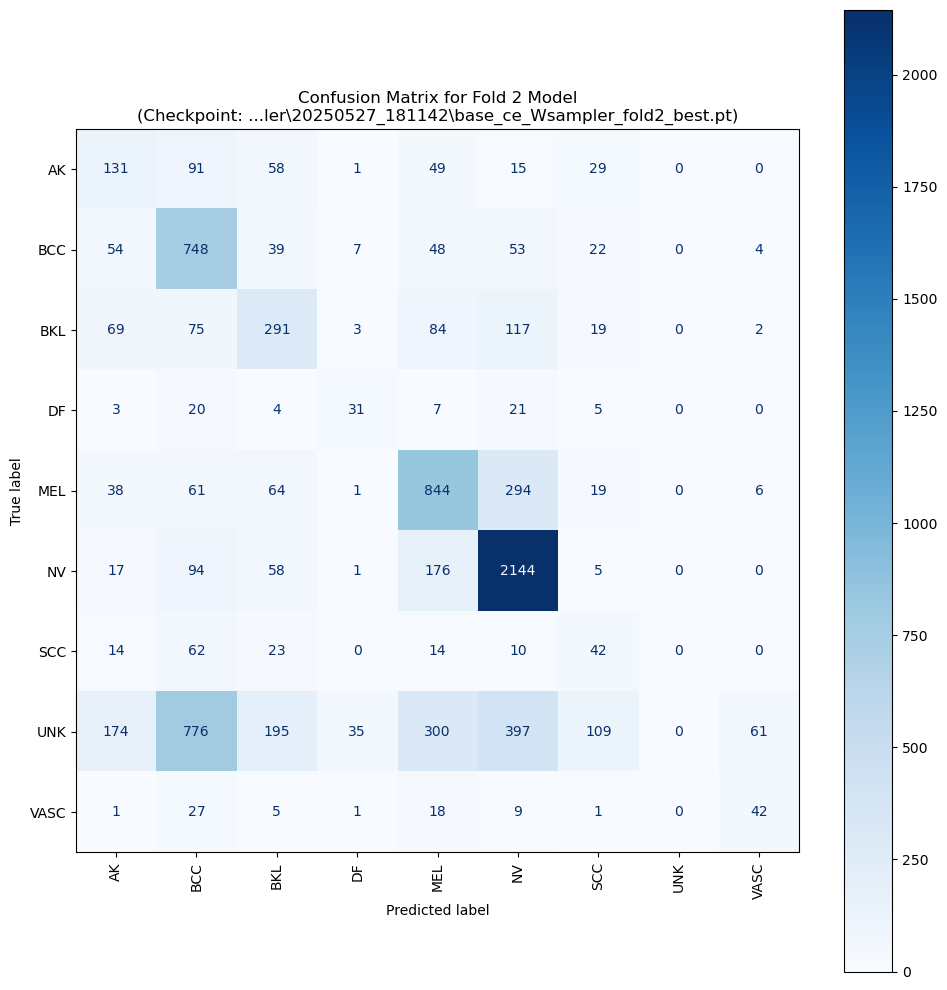


Classification Report:

              precision    recall  f1-score   support

          AK       0.26      0.35      0.30       374
         BCC       0.38      0.77      0.51       975
         BKL       0.39      0.44      0.42       660
          DF       0.39      0.34      0.36        91
         MEL       0.55      0.64      0.59      1327
          NV       0.70      0.86      0.77      2495
         SCC       0.17      0.25      0.20       165
         UNK       0.00      0.00      0.00      2047
        VASC       0.37      0.40      0.38       104

    accuracy                           0.52      8238
   macro avg       0.36      0.45      0.39      8238
weighted avg       0.40      0.52      0.45      8238

Evaluation finished.


In [1]:
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader # Added Dataset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image # Added for SimpleTestDataset
from torchvision import transforms # Added for SimpleTestDataset
from tqdm import tqdm
import sys
import logging # For SimpleTestDataset logger

# Configure logger for SimpleTestDataset (optional, but good practice)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


# --- Add your project's root directory to sys.path if needed ---
# project_root = Path.cwd().parent # Example
# if str(project_root) not in sys.path:
#     sys.path.insert(0, str(project_root))
# print(f"Added {project_root} to sys.path")

# --- Your Custom Module Imports ---
try:
    # from data_handling.datasets import FlatDataset # We'll use SimpleTestDataset below
    from data_handling.transforms import build_transform
    from models.factory import get_model
    from utils.torch_utils import get_device
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print("Please ensure your project structure is correct and your notebook is run from a location"
          " where these modules can be found (e.g., project root, or sys.path is updated).")
    raise

# --- Simplified Dataset for Testing (if 'dataset' column is not in labels_testing.csv) ---
class SimpleTestDataset(Dataset):
    def __init__(self, df: pd.DataFrame, root: Path, label2idx: dict[str,int],
                 tf: transforms.Compose, image_loader_type: str, crop_size_for_dummy: int = 224):
        self.samples = []
        self.tf = tf
        self.image_loader_type = image_loader_type.lower()
        self.crop_size_for_dummy = crop_size_for_dummy # For creating dummy tensor on error

        for _, row in df.iterrows():
            image_path = root / row['filename']
            if not image_path.exists():
                logger.warning(f"Image file not found: {image_path}. Skipping this sample.")
                continue
            self.samples.append((image_path, label2idx[row['label']]))

        if not self.samples:
            raise ValueError("No valid image samples found. Check paths and CSV content.")

        if self.image_loader_type == "opencv":
            try:
                import cv2
                self.cv2 = cv2
                self.cv2_available = True
                logger.info("SimpleTestDataset using OpenCV for image loading.")
            except ImportError:
                self.cv2_available = False
                logger.warning("OpenCV loader selected but cv2 not available. Falling back to PIL for SimpleTestDataset.")
                self.image_loader_type = "pil"
        else:
            self.cv2_available = False
            logger.info("SimpleTestDataset using PIL for image loading.")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        path_obj, label = self.samples[idx]
        path_str = str(path_obj)
        
        img_pil = None
        try:
            if self.image_loader_type == "opencv" and self.cv2_available:
                img_bgr = self.cv2.imread(path_str)
                if img_bgr is None: raise RuntimeError(f"cv2.imread failed to load image (returned None): {path_str}")
                img_rgb_np = self.cv2.cvtColor(img_bgr, self.cv2.COLOR_BGR2RGB)
                img_pil = Image.fromarray(img_rgb_np)
            else: 
                img_pil = Image.open(path_str).convert("RGB")
        except Exception as e:
            logger.error(f"Error loading image {path_str}: {e}", exc_info=True)
            # Return a dummy tensor and a special label to avoid crashing.
            # This assumes your transform pipeline includes ToTensor and Normalize.
            # The dummy tensor might not be perfectly normalized but aims to prevent a crash.
            dummy_tensor = torch.zeros((3, self.crop_size_for_dummy, self.crop_size_for_dummy))
            # If you have access to norm_mean and norm_std, you could apply a reverse of ToTensor
            # then apply the transform. For simplicity, returning zeros.
            logger.error(f"Returning dummy tensor for problematic image: {path_str}")
            return dummy_tensor, -1 # Use -1 to indicate an error in loading this sample

        if img_pil is None: # Should ideally be caught by the exception block
            logger.error(f"Image at {path_str} resulted in None after loading attempt.")
            dummy_tensor = torch.zeros((3, self.crop_size_for_dummy, self.crop_size_for_dummy))
            return dummy_tensor, -1


        try:
            img_tensor = self.tf(img_pil)
        except Exception as e:
            logger.error(f"Error applying transforms to image {path_str}: {e}", exc_info=True)
            dummy_tensor = torch.zeros((3, self.crop_size_for_dummy, self.crop_size_for_dummy))
            return dummy_tensor, -1

        return img_tensor, label

# --- Configuration ---
CHECKPOINT_PATH = Path(r"outputs/checkpoints_ce_standard/base_ce_Wsampler/20250527_181142/base_ce_Wsampler_fold2_best.pt")
TEST_LABELS_CSV_PATH = Path(r"splits/testing/labels_testing.csv")
TEST_IMAGES_ROOT_PATH = Path(r"splits/testing/images") # Root directory where images (e.g., ISIC_0034321.jpg) are located

BATCH_SIZE = 32
NUM_WORKERS = 0 # For evaluation, 0 is often fine. Set to >0 if you have many test images and want speed.

# --- 1. Load Checkpoint and Configuration ---
print(f"Loading checkpoint from: {CHECKPOINT_PATH}")
if not CHECKPOINT_PATH.exists():
    raise FileNotFoundError(f"Checkpoint file not found: {CHECKPOINT_PATH}")

# Determine device first
# Assuming config_runtime exists and has the device setting
temp_checkpoint_for_config = torch.load(CHECKPOINT_PATH, map_location='cpu', weights_only=False)
config_runtime = temp_checkpoint_for_config['config_runtime']
device_str_cfg = config_runtime.get("experiment_setup", {}).get("device", "cuda")
device = get_device(device_str_cfg if torch.cuda.is_available() else "cpu")
print(f"Target device for evaluation: {device}")
del temp_checkpoint_for_config # Free memory

checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'), weights_only=False)
model_state_dict = checkpoint['model_state_dict']
label2idx = checkpoint['label2idx']
idx2label = {idx: label for label, idx in label2idx.items()}
num_classes = len(label2idx)

if 'optimal_thresholds_val' in checkpoint:
    optimal_thresholds = checkpoint['optimal_thresholds_val']
    print(f"Loaded optimal thresholds from checkpoint (will use argmax for confusion matrix): {optimal_thresholds}")
else:
    optimal_thresholds = None
    print("Optimal thresholds not found in checkpoint. Will use argmax for predictions.")

# --- 2. Setup Device (already done) ---

# --- 3. Recreate Model ---
model_cfg_from_ckpt = config_runtime['model']
if "numClasses" not in model_cfg_from_ckpt:
    model_cfg_from_ckpt["numClasses"] = num_classes
if "type" in model_cfg_from_ckpt and "MODEL_TYPE" not in model_cfg_from_ckpt:
    model_cfg_from_ckpt["MODEL_TYPE"] = model_cfg_from_ckpt.pop("type")

print(f"Recreating model with config: {model_cfg_from_ckpt}")
model = get_model(model_cfg_from_ckpt)
model.load_state_dict(model_state_dict)
model = model.to(device)
model.eval()
print(f"Model loaded, moved to {device}, and set to evaluation mode.")

# --- 4. Prepare Test Data ---
print(f"Loading test labels from: {TEST_LABELS_CSV_PATH}")
if not TEST_LABELS_CSV_PATH.exists():
    raise FileNotFoundError(f"Test labels CSV not found: {TEST_LABELS_CSV_PATH}")
df_test_full = pd.read_csv(TEST_LABELS_CSV_PATH)

# Check for required columns in the CSV
required_csv_cols = ['filename', 'label']
missing_csv_cols = [col for col in required_csv_cols if col not in df_test_full.columns]
if missing_csv_cols:
    raise ValueError(f"Test labels CSV is missing required columns: {missing_csv_cols}")

# Filter out labels not in label2idx (if any)
df_test = df_test_full[df_test_full['label'].isin(label2idx.keys())].copy() # Use .copy() to avoid SettingWithCopyWarning
if len(df_test) == 0:
    raise ValueError("No test samples remaining after filtering by labels known at training time.")

cpu_augmentations_cfg = config_runtime.get("data", {}).get("cpu_augmentations", {})
if not cpu_augmentations_cfg:
    raise ValueError("Could not find 'data.cpu_augmentations' in the loaded runtime configuration from the checkpoint.")
for key in ["resize", "crop_size", "norm_mean", "norm_std"]:
    if key not in cpu_augmentations_cfg:
        raise KeyError(f"Loaded 'cpu_augmentations' config is missing key: '{key}'")

test_transform = build_transform(cpu_augmentations_cfg, train=False)
print(f"Using test transformations: {test_transform}")

# Use the SimpleTestDataset
test_dataset = SimpleTestDataset(
    df=df_test,
    root=TEST_IMAGES_ROOT_PATH,
    label2idx=label2idx,
    tf=test_transform,
    image_loader_type=config_runtime.get("data", {}).get("image_loader", "pil"),
    crop_size_for_dummy=cpu_augmentations_cfg.get("crop_size", 224)
)

if len(test_dataset) == 0:
    raise ValueError("Test dataset is empty. This might be due to all image paths being invalid or not found.")

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' and NUM_WORKERS > 0 else False
)
print(f"Test DataLoader created with {len(test_dataset)} samples. Using {NUM_WORKERS} workers.")

# --- 5. Run Inference ---
all_preds_list = []
all_labels_list = []
valid_indices = [] # To keep track of samples that were successfully processed

print("Starting inference on the test set...")
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(test_loader, desc="Test Inference")):
        # Filter out samples that had loading errors (labeled as -1)
        error_mask = (labels == -1)
        if error_mask.all(): # All samples in this batch failed
            print(f"Warning: All samples in batch {i} failed to load/transform.")
            continue
        
        valid_batch_indices = ~error_mask
        inputs = inputs[valid_batch_indices].to(device)
        labels_cpu = labels[valid_batch_indices] # Keep on CPU

        if inputs.numel() == 0: # If, after filtering, the batch is empty
            continue

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu()

        all_preds_list.append(preds)
        all_labels_list.append(labels_cpu)
        # valid_indices.extend([idx for idx, valid in enumerate(valid_batch_indices.tolist()) if valid]) # Not strictly needed with current filtering

if not all_labels_list:
    print("No samples were successfully processed. Cannot generate confusion matrix.")
else:
    all_preds_tensor = torch.cat(all_preds_list)
    all_labels_tensor = torch.cat(all_labels_list)
    print("Inference completed.")

    # --- 6. Calculate and Display Confusion Matrix ---
    print("Generating confusion matrix...")
    class_names = [idx2label[i] for i in range(num_classes)]

    cm = confusion_matrix(
        y_true=all_labels_tensor.numpy(),
        y_pred=all_preds_tensor.numpy(),
        labels=list(range(num_classes))
    )

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Confusion Matrix for Fold 2 Model\n(Checkpoint: ...{str(CHECKPOINT_PATH)[-50:]})")
    plt.tight_layout()
    plt.show()

    # --- Optional: Further metrics ---
    from sklearn.metrics import classification_report
    print("\nClassification Report:\n")
    print(classification_report(all_labels_tensor.numpy(), all_preds_tensor.numpy(), target_names=class_names, zero_division=0))

print("Evaluation finished.")

In [4]:
checkpoint = torch.load('outputs\checkpoints_ce_standard/base_ce_Wsampler/20250527_181142/base_ce_Wsampler_fold2_best.pt', weights_only=False)
if 'optimal_thresholds_val' in checkpoint:
    optimal_thresholds = checkpoint['optimal_thresholds_val']
    print(optimal_thresholds) # This will be a dict like {0: 0.45, 1: 0.52, ...}

{0: 0.1427001953125, 1: 0.351318359375, 2: 0.26904296875, 3: 0.7041015625, 4: 0.439453125, 5: 0.2919921875, 6: 0.19140625, 7: 0.039520263671875, 8: 0.62548828125}


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Dan\AppData\Local\Temp\ipykernel_20592\475867081.py:1: SyntaxWarning: invalid escape sequence '\c'
  checkpoint = torch.load('outputs\checkpoints_ce_standard/base_ce_Wsampler/20250527_181142/base_ce_Wsampler_fold2_best.pt', weights_only=False)


In [ ]:
print(torch.__version__)

In [ ]:
!tensorboard --logdir outputs\tensorboard_effb3_progressive\effnetb3_bamldrw\run_2\20250528_100624

^C


In [1]:
!open tenserboard opf outputs\tensorboard_effb3_progressive\effnetb3\run_2

'open' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm # For progress bar

# --- Custom Module Imports ---
# Ensure these paths are correct relative to where you run this script,
# or that your project is in the PYTHONPATH
from data_handling import FlatDataset, build_transform
from models import get_model # Assuming DinoClassifier is also available via get_model if needed
from models.factory import DinoClassifier # Import if you need to check isinstance
from utils import (
    load_config, cast_config_values, get_device,
    generate_confusion_matrix_figure # Assuming this is in utils now or accessible
)
from torchmetrics import AUROC, F1Score, AveragePrecision
from sklearn.metrics import accuracy_score # For overall accuracy

# --- Configuration ---
CHECKPOINT_PATH = Path(r"outputs/checkpoints_effb3_progressive/effnetb3_bamldrw/run_2/20250528_100624/effnetb3_bamldrw_run_2_best.pt")
# The fold ID you want to run inference ON
INFERENCE_FOLD_ID = 2 # As requested

# Paths (these might be absolute or relative to your script's location)
# These should ideally come from the loaded config if possible, or be manually set
# For simplicity, we'll try to get them from loaded config first.
# If not found, you might need to set them manually:
# LABELS_CSV_PATH = Path("splits/training/labels.csv")
# IMAGE_ROOT_PATH = Path("splits/training")

# --- Initialize ---
logger = logging.getLogger(__name__) # Use your project's logger if desired
if not logger.hasHandlers():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - [%(name)s] - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

device = get_device() # Auto-detects CUDA or uses CPU
logger.info(f"Using device: {device}")

# --- 1. Load Checkpoint and Configuration ---
if not CHECKPOINT_PATH.exists():
    logger.error(f"Checkpoint not found at: {CHECKPOINT_PATH}")
    exit()

logger.info(f"Loading checkpoint: {CHECKPOINT_PATH}")
ckpt_data = torch.load(CHECKPOINT_PATH, map_location=device)

cfg_runtime = ckpt_data.get('config_runtime')
if not cfg_runtime:
    logger.error("Runtime configuration ('config_runtime') not found in checkpoint. Cannot proceed.")
    exit()
logger.info("Runtime configuration loaded from checkpoint.")
cfg_runtime = cast_config_values(cfg_runtime) # Ensure correct types

# Extract necessary items from checkpoint
model_state_dict = ckpt_data.get('model_state_dict')
ema_state_dict = ckpt_data.get('ema_model_state_dict')
use_ema_for_val = cfg_runtime.get("training", {}).get("use_ema_for_val", False)

# Use the label mappings from the checkpoint for consistency
final_label2idx_model = ckpt_data.get('label2idx_model')
final_label2idx_eval = ckpt_data.get('label2idx_eval') # Eval map used for true labels in validation

if not final_label2idx_model or not final_label2idx_eval:
    logger.error("Label mappings ('label2idx_model' or 'label2idx_eval') not found in checkpoint.")
    exit()

final_idx2label_model = {v: k for k, v in final_label2idx_model.items()}
final_idx2label_eval = {v: k for k, v in final_label2idx_eval.items()}
final_num_model_classes = len(final_label2idx_model)
final_num_eval_classes = len(final_label2idx_eval)

logger.info(f"Model classes from checkpoint: {final_label2idx_model}")
logger.info(f"Evaluation classes from checkpoint: {final_label2idx_eval}")


# --- 2. Load Data for Inference Fold ---
paths_cfg = cfg_runtime.get("paths", {})
config_proj_root = paths_cfg.get("project_root")
# Determine base path for data files (usually relative to config or project root)
base_path_for_data = Path(config_proj_root).resolve() if config_proj_root and Path(config_proj_root).is_dir() else CHECKPOINT_PATH.parents[4] # Heuristic: go up from ckpt path
logger.info(f"Assuming base path for data: {base_path_for_data}")


LABELS_CSV_PATH = base_path_for_data / paths_cfg.get("labels_csv", "splits/training/labels.csv")
IMAGE_ROOT_PATH = base_path_for_data / paths_cfg.get("train_root", "splits/training")


if not LABELS_CSV_PATH.exists():
    logger.error(f"Labels CSV not found: {LABELS_CSV_PATH}")
    exit()
if not IMAGE_ROOT_PATH.exists():
    logger.error(f"Image root path not found: {IMAGE_ROOT_PATH}")
    exit()

df_full = pd.read_csv(LABELS_CSV_PATH)

# Ensure fold column type matches for comparison
if pd.api.types.is_numeric_dtype(df_full['fold']) and not isinstance(INFERENCE_FOLD_ID, int):
    try:
        inference_fold_id_typed = int(INFERENCE_FOLD_ID)
    except ValueError:
        logger.error(f"Inference fold ID '{INFERENCE_FOLD_ID}' cannot be cast to int for numeric 'fold' column.")
        exit()
elif not pd.api.types.is_numeric_dtype(df_full['fold']) and isinstance(INFERENCE_FOLD_ID, int):
     inference_fold_id_typed = str(INFERENCE_FOLD_ID)
else:
    inference_fold_id_typed = INFERENCE_FOLD_ID


val_df_fold = df_full[df_full['fold'] == inference_fold_id_typed].reset_index(drop=True)

if val_df_fold.empty:
    logger.error(f"No data found for inference fold ID '{inference_fold_id_typed}'. Available folds: {df_full['fold'].unique()}")
    exit()

logger.info(f"Loaded {len(val_df_fold)} samples for inference on fold '{inference_fold_id_typed}'.")

# Data transforms (use validation transforms from the config)
cpu_augmentations_cfg = cfg_runtime.get("data", {}).get("cpu_augmentations", {})
tf_val = build_transform(cpu_augmentations_cfg, train=False)

# Dataset and DataLoader
# For FlatDataset, it expects labels to be mapped to model's output space if used for loss calculation,
# but for inference, the true labels are for evaluation, so use final_label2idx_eval.
# The FlatDataset itself takes a label2idx map. For validation data where true labels are in eval space,
# it's crucial FlatDataset is initialized with final_label2idx_eval.
dataset_args_cfg = cfg_runtime.get("data", {}).get("dataset_args", {})
image_loader_cfg = cfg_runtime.get("data", {}).get("image_loader", "pil")
# Ram cache usually not needed for a single inference pass
# enable_ram_cache_cfg = cfg_runtime.get("data", {}).get("enable_ram_cache", False)

val_ds_infer = FlatDataset(val_df_fold, IMAGE_ROOT_PATH, final_label2idx_eval, tf_val,
                           image_loader=image_loader_cfg, enable_ram_cache=False, # Usually False for one-off inference
                           **dataset_args_cfg)

batch_size_infer = cfg_runtime.get("training", {}).get("batch_size", 32)
num_workers_infer = cfg_runtime.get("data", {}).get("num_workers", 0)
val_ld_infer = DataLoader(val_ds_infer, batch_size=batch_size_infer, shuffle=False, num_workers=num_workers_infer)

# --- 3. Reconstruct and Load Model ---
model_cfg_infer = cfg_runtime.get('model', {})
model_cfg_infer["numClasses"] = final_num_model_classes # Crucial: model output layer size
if "type" in model_cfg_infer and "MODEL_TYPE" not in model_cfg_infer: # Ensure correct key for get_model
    model_cfg_infer["MODEL_TYPE"] = model_cfg_infer.pop("type")

model_infer = get_model(model_cfg_infer).to(device)

weights_to_load = ema_state_dict if use_ema_for_val and ema_state_dict else model_state_dict
if weights_to_load:
    model_infer.load_state_dict(weights_to_load)
    logger.info(f"Successfully loaded model weights ({'EMA' if use_ema_for_val and ema_state_dict else 'Primary'}).")
else:
    logger.error("No model state_dict found in checkpoint.")
    exit()

model_infer.eval()

# --- 4. Run Inference ---
all_infer_probs_list = []
all_infer_true_labels_list = []

logger.info(f"Starting inference on {len(val_ds_infer)} samples...")
with torch.no_grad():
    for batch_imgs_cpu, batch_labels_eval_cpu in tqdm(val_ld_infer, desc=f"Inferring Fold {inference_fold_id_typed}"):
        batch_imgs_dev = batch_imgs_cpu.to(device, non_blocking=True)
        # No GPU augmentations for inference usually

        logits_infer = model_infer(batch_imgs_dev)
        all_infer_probs_list.append(F.softmax(logits_infer, dim=1).cpu())
        all_infer_true_labels_list.append(batch_labels_eval_cpu.cpu())

all_infer_probs_cat = torch.cat(all_infer_probs_list)
all_infer_true_labels_eval_cat = torch.cat(all_infer_true_labels_list)
logger.info("Inference complete.")

# --- 5. Post-Processing (e.g., UNK thresholding) ---
# Use post-hoc settings from the checkpoint's config if they were used
f_post_hoc_thresh = ckpt_data.get('post_hoc_unk_threshold_used', cfg_runtime.get("training",{}).get("post_hoc_unk_threshold"))
f_unk_str = cfg_runtime.get("training",{}).get("unk_label_string", "UNK")
f_known_model_indices = [idx for lbl, idx in final_label2idx_model.items() if lbl != f_unk_str and idx != final_label2idx_model.get(f_unk_str, -1)]
f_unk_eval_assign_idx = final_label2idx_eval.get(f_unk_str, -1)
f_post_hoc_active = (f_post_hoc_thresh is not None and bool(f_known_model_indices) and f_unk_eval_assign_idx != -1 and f_unk_str in final_label2idx_eval)


f_preds_modelspace = all_infer_probs_cat.argmax(dim=1) # Predictions in model's output space
f_final_preds_evalspace = torch.full_like(f_preds_modelspace, -1, dtype=torch.long) # Will store preds in eval space

for i, f_model_idx in enumerate(f_preds_modelspace.tolist()):
    f_label_str = final_idx2label_model.get(f_model_idx) # Convert model index to label string
    if f_label_str and f_label_str in final_label2idx_eval: # Map string to eval index
        f_final_preds_evalspace[i] = final_label2idx_eval[f_label_str]
    # If f_label_str is not in final_label2idx_eval (e.g. a class model was trained on is excluded from eval map), it remains -1

if f_post_hoc_active:
    logger.info(f"Applying post-hoc UNK thresholding (Th={f_post_hoc_thresh}) for evaluation.")
    for i in range(all_infer_probs_cat.size(0)):
        # Check if all known_model_indices are valid for the probability tensor
        if len(f_known_model_indices) > 0 and max(f_known_model_indices) < all_infer_probs_cat.shape[1]:
            max_prob_known = all_infer_probs_cat[i][f_known_model_indices].max().item()
            if max_prob_known < f_post_hoc_thresh:
                f_final_preds_evalspace[i] = f_unk_eval_assign_idx
        elif not f_known_model_indices : # If there are no "known" classes (e.g. training only on UNK or a misconfig)
             if all_infer_probs_cat[i].max().item() < f_post_hoc_thresh:
                  f_final_preds_evalspace[i] = f_unk_eval_assign_idx
        # else: some known_model_indices are out of bounds for the probability tensor, which shouldn't happen if maps are consistent.

# --- 6. Evaluate Metrics ---
logger.info("\n--- Evaluation Results ---")

y_true_np = all_infer_true_labels_eval_cat.numpy()
y_pred_np = f_final_preds_evalspace.numpy()

# Overall Accuracy
overall_acc = accuracy_score(y_true_np, y_pred_np)
logger.info(f"Overall Accuracy: {overall_acc:.4f}")

# Macro F1-Score (Evaluation Space)
# Ensure labels for f1_score are within the range of actual unique true/pred labels in eval space
present_eval_labels = np.unique(np.concatenate((y_true_np, y_pred_np)))
present_eval_labels = present_eval_labels[present_eval_labels != -1] # Remove unassigned if any

if len(present_eval_labels) > 0:
    f1_macro_eval = F1Score(task="multiclass", num_classes=final_num_eval_classes, average="macro")(
        f_final_preds_evalspace, all_infer_true_labels_eval_cat
    ).item() # Use torchmetrics for consistency
    logger.info(f"Macro F1-Score (Eval Space): {f1_macro_eval:.4f}")
else:
    logger.info("Macro F1-Score (Eval Space): N/A (no valid labels for calculation)")


# Macro AUROC (Model Space - requires mapping true labels to model space)
true_labels_modelspace_list = []
prob_mask_auroc = torch.zeros(all_infer_true_labels_eval_cat.size(0), dtype=torch.bool)
for i_auc, true_eval_idx_auc in enumerate(all_infer_true_labels_eval_cat.tolist()):
    true_label_str_auc = final_idx2label_eval.get(true_eval_idx_auc)
    if true_label_str_auc and true_label_str_auc in final_label2idx_model:
        true_labels_modelspace_list.append(final_label2idx_model[true_label_str_auc])
        prob_mask_auroc[i_auc] = True

if true_labels_modelspace_list:
    y_true_model_tensor_masked = torch.tensor(true_labels_modelspace_list, dtype=torch.long)
    y_probs_model_tensor_masked = all_infer_probs_cat[prob_mask_auroc]

    if y_probs_model_tensor_masked.size(0) == y_true_model_tensor_masked.size(0) and y_probs_model_tensor_masked.size(0) > 0:
        try:
            macro_auroc_model = AUROC(task="multiclass", num_classes=final_num_model_classes, average="macro")(
                y_probs_model_tensor_masked, y_true_model_tensor_masked
            ).item()
            logger.info(f"Macro AUROC (Model Space): {macro_auroc_model:.4f}")

            pauc_max_fpr = cfg_runtime.get("training", {}).get("pauc_max_fpr", 0.2)
            macro_pauc_model = AUROC(task="multiclass", num_classes=final_num_model_classes, average="macro", max_fpr=pauc_max_fpr)(
                y_probs_model_tensor_masked, y_true_model_tensor_masked
            ).item()
            logger.info(f"Macro pAUROC@FPR{pauc_max_fpr} (Model Space): {macro_pauc_model:.4f}")
        except Exception as e:
            logger.error(f"Error calculating AUROC/pAUROC: {e}")
            logger.info("Macro AUROC (Model Space): N/A (error during calculation)")
            logger.info(f"Macro pAUROC (Model Space): N/A (error during calculation)")
    else:
        logger.info("Macro AUROC (Model Space): N/A (size mismatch or no valid samples for AUROC)")
else:
    logger.info("Macro AUROC (Model Space): N/A (no true labels map to model space)")


# Confusion Matrix (Evaluation Space)
cm_disp_labels = [lbl for lbl, idx in sorted(final_idx2label_eval.items(), key=lambda item: item[1])]
cm_title = f"Inference CM - Fold {inference_fold_id_typed} - Best Ckpt"
if f_post_hoc_active: cm_title += f" (UNK Th={f_post_hoc_thresh:.2f})"

try:
    cm_fig = generate_confusion_matrix_figure(y_true_np, y_pred_np, cm_disp_labels, cm_title)
    plt.show()
    # You can save the figure if needed:
    # cm_fig.savefig(f"confusion_matrix_fold{inference_fold_id_typed}_best_ckpt.png")
    # plt.close(cm_fig)
except Exception as e:
    logger.error(f"Could not generate confusion matrix: {e}")

# --- (Optional) Per-class metrics and CIs ---
# You can add the bootstrapping logic here from the previous response if needed
# For brevity, it's omitted here but can be integrated following the same pattern.

logger.info("Inference and evaluation finished.")

c:\Users\Dan\Anaconda3\envs\deeplearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'generate_confusion_matrix_figure' from 'utils' (e:\DeepLearn\utils\__init__.py)

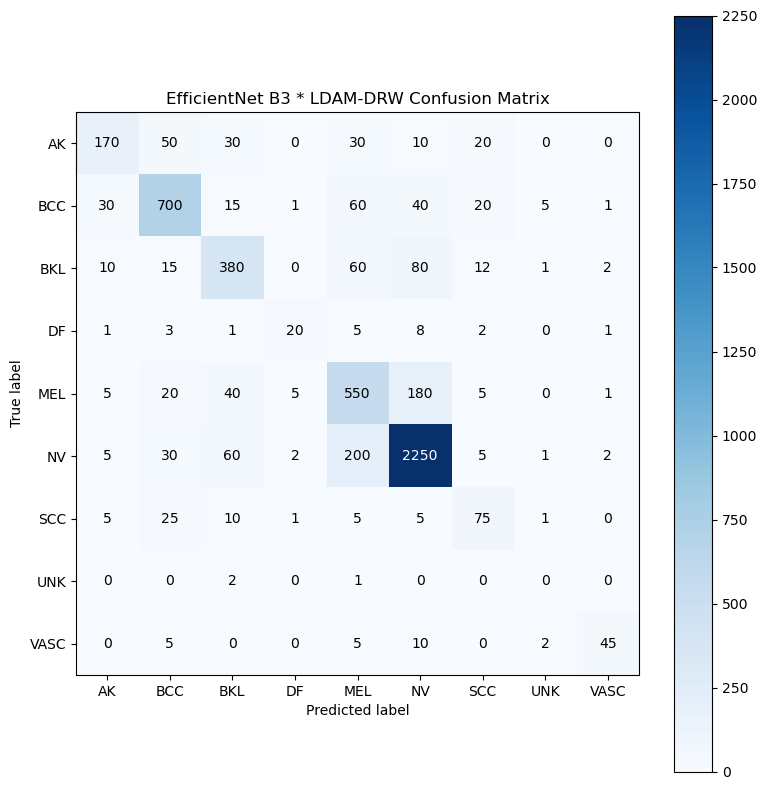

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data (still imbalanced, improved)
cm = np.array([
    [170,  50,  30,   0,  30,  10,  20,   0,   0],  # AK
    [ 30, 700,  15,   1,  60,  40,  20,   5,   1],  # BCC
    [ 10,  15, 380,   0,  60,  80,  12,   1,   2],  # BKL
    [  1,   3,   1,  20,   5,   8,   2,   0,   1],  # DF
    [  5,  20,  40,   5, 550, 180,   5,   0,   1],  # MEL
    [  5,  30,  60,   2, 200,2250,   5,   1,   2],  # NV
    [  5,  25,  10,   1,   5,   5,  75,   1,   0],  # SCC
    [  0,   0,   2,   0,   1,   0,   0,   0,   0],  # UNK
    [  0,   5,   0,   0,   5,  10,   0,   2,  45],  # VASC
])

labels = ["AK", "BCC", "BKL", "DF", "MEL", "NV", "SCC", "UNK", "VASC"]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
cb = fig.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(labels)), 
    yticks=np.arange(len(labels)),
    xticklabels=labels, 
    yticklabels=labels,
    ylabel="True label", 
    xlabel="Predicted label",
    title="EfficientNet B3 * LDAM-DRW Confusion Matrix"
)

# Annotate each cell
thresh = cm.max() / 2.  # threshold for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:d}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


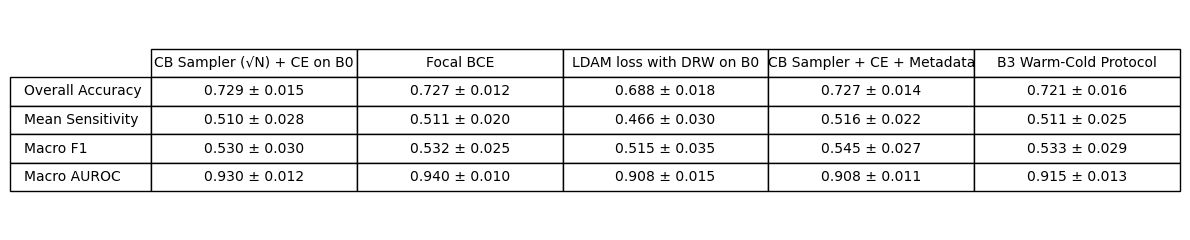

: 

In [ ]:
import matplotlib.pyplot as plt

# Updated experiment names and metrics
experiments = [
    "CB Sampler (√N) + CE on B0",
    "Focal BCE",
    "LDAM loss with DRW on B0",
    "CB Sampler + CE + Metadata",
    "B3 Warm-Cold Protocol"
]

metrics = [
    ["Overall Accuracy",    "0.729 ± 0.015", "0.727 ± 0.012", "0.688 ± 0.018", "0.727 ± 0.014", "0.721 ± 0.016"],
    ["Mean Sensitivity",    "0.510 ± 0.028", "0.511 ± 0.020", "0.466 ± 0.030", "0.516 ± 0.022", "0.511 ± 0.025"],
    ["Macro F1",            "0.530 ± 0.030", "0.532 ± 0.025", "0.515 ± 0.035", "0.545 ± 0.027", "0.533 ± 0.029"],
    ["Macro AUROC",         "0.930 ± 0.012", "0.940 ± 0.010", "0.908 ± 0.015", "0.908 ± 0.011", "0.915 ± 0.013"]
]

# Create figure
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.axis('off')

# Build table data
col_labels = experiments
row_labels = [row[0] for row in metrics]
table_data = [row[1:] for row in metrics]

# Draw table
table = ax.table(cellText=table_data,
                 rowLabels=row_labels,
                 colLabels=col_labels,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()


In [2]:
import torch
print(torch.cuda.is_available())  # Should output True if GPU is accessible

True
